# Service Components

***
* Downloaded service-components data from the "market analysis" view. 
* "Components" column  reflects what the organizations <b>actually</b> use a particular product for.
    * Renamed to "components_orgs_actually_use" to make this a little clearer.

In [1]:
import numpy as np
import pandas as pd

pd.options.display.max_columns = 64
pd.set_option("display.max_rows", None)
pd.set_option("display.max_colwidth", None)
pd.options.display.float_format = "{:.2f}".format

from collections import Counter
from itertools import chain
from os import path

import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import utils
from calitp import *
from IPython.display import HTML, Image, Markdown, display, display_html
from PIL import Image
from shared_utils import altair_utils
from siuba import *

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/transit_stacks/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [2]:
service_components = to_snakecase(
    pd.read_csv(f"{GCS_FILE_PATH}service-components-Market Analysis.csv")
)

In [3]:
f"{len(service_components)} rows"

'1032 rows'

In [4]:
service_components.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032 entries, 0 to 1031
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype 
---  ------                                            --------------  ----- 
 0   name                                              1032 non-null   object
 1   services                                          1027 non-null   object
 2   component                                         1030 non-null   object
 3   vendor__from_product_                             950 non-null    object
 4   parent_organization__from_vendor___from_product_  247 non-null    object
 5   provider__from_services_                          1027 non-null   object
 6   product                                           1030 non-null   object
 7   product_components                                973 non-null    object
dtypes: object(8)
memory usage: 64.6+ KB


In [5]:
# Fill in N/A and rename cols to be a little clearer.
service_components = service_components.fillna("N/A").rename(
    columns={
        "component": "components_orgs_actually_use",
        "product_components": "all_components_in_product",
    }
)

In [6]:
# Drop Duplicates
service_components = service_components.drop_duplicates()

In [7]:
display(
    Markdown(
        f"The length of the dataframe went down to {len(service_components)} after dropping duplicates"
        "<br>"
        f"There are {service_components.services.nunique()} different organizations."
        "<br>"
        f" There are {service_components.components_orgs_actually_use.nunique()} different components."
    )
)

The length of the dataframe went down to 1023 after dropping duplicates<br>There are 156 different organizations.<br> There are 26 different components.

In [8]:
# Copy dataframe to not mess the original one.
service_components2 = service_components.copy()

In [9]:
# Find if a value in "components_usage" matches a value in "all components in product" column because sometimes, they don't match?
# If there is at least one match, tag as "True."

# https://stackoverflow.com/questions/21514191/check-if-pandas-column-contains-value-from-another-column
service_components2["contained"] = service_components2.apply(
    lambda x: x.components_orgs_actually_use in x.all_components_in_product, axis=1
)

In [10]:
# Double check that this worked properly.
service_components2[
    [
        "services",
        "product",
        "components_orgs_actually_use",
        "all_components_in_product",
        "contained",
    ]
].sample(3)

,services,product,components_orgs_actually_use,all_components_in_product,contained
217,Glendale Beeline,Excel,GTFS generation,General Purpose Software,False
865,Big Blue Bus,Stripe,Payment processor,Payment processor,True
978,SamTrans,Bytemark - Trip Planning App,Mobile trip planning app,Mobile trip planning app,True


In [11]:
# Count how many true and false.
service_components2.contained.value_counts()

False    548
True     475
Name: contained, dtype: int64

## Summarizing the DataFrame
***
* It looks like some services/organizations use the same product from the same vendor for 1+ components but this is split on 2 lines.
    * Example: Tuolumne County Transit uses Doublemap RealTime product for both real-time and arrival predictions. 
    * However, 'real-time' and 'arrival predictions' are split on  different lines, even though they reference the same product, vendor, and customer.
    * <img src="Example_Tuolumne.png" width=1000 height=400 />
* Group/summarize so the same service-vendor-product combination on the same line to avoid duplicate entires.

In [12]:
# Copy dataframe to not mess the original one.
service_components3 = service_components2.copy()

In [13]:
# Group the column "components_orgs_actually_use" based on services/organizations, vendor, and product
service_components3["components_usage"] = service_components3.groupby(
    ["services", "vendor__from_product_", "product"]
)["components_orgs_actually_use"].transform(lambda x: ",".join(x))

In [14]:
# Sort dataframe by the columns "product" and "contained". Thus, if a product-company-agency combination has one true, we would capture it.
service_components3 = service_components3.sort_values(
    by=["product", "contained"], ascending=False
)

In [15]:
# Drop the  duplicates by duplicates
service_components3 = service_components3.drop_duplicates(
    subset=["services", "product", "vendor__from_product_", "components_usage"],
    keep="first",
)

In [16]:
# Keep only columns of interest
service_components3 = service_components3[
    [
        "services",
        "vendor__from_product_",
        "provider__from_services_",
        "parent_organization__from_vendor___from_product_",
        "product",
        "all_components_in_product",
        "components_usage",
        "contained",
    ]
]

In [17]:
# Double checking
service_components3[
    (service_components3.services.str.contains("GET Bus,GET Bus On Demand", case=False))
]

,services,vendor__from_product_,provider__from_services_,parent_organization__from_vendor___from_product_,product,all_components_in_product,components_usage,contained
35,"GET Bus,GET Bus On Demand",Worldpay,"Golden Empire Transit District, Golden Empire Transit District",Fidelity National Information Services,Worldpay,Payment processor,Payment processor,True
2,"GET Bus,GET Bus On Demand",UTA,"Golden Empire Transit District, Golden Empire Transit District",N/A,UTA APC Software,APC Software,APC Software,True
58,"GET Bus,GET Bus On Demand",Transit App Inc.,"Golden Empire Transit District, Golden Empire Transit District",N/A,Transit App,Mobile trip planning app,Alerts Content Management System,False
8,"GET Bus,GET Bus On Demand",TransTrack Solutions Group,"Golden Empire Transit District, Golden Empire Transit District",N/A,TransTrack Manager,"Data Analysis/GIS/Modelling Software,KPI Reporting",KPI Reporting,True
1,"GET Bus,GET Bus On Demand",Token Transit,"Golden Empire Transit District, Golden Empire Transit District",N/A,Token Transit Mobile Ticketing,Mobile ticketing,Mobile ticketing,True
96,"GET Bus,GET Bus On Demand",SunriseSESA,"Golden Empire Transit District, Golden Empire Transit District",N/A,Sunrise CDP,"General Signage ,Interior signage,Headsigns,Side signs",Offboard signage,False
17,"GET Bus,GET Bus On Demand",Optibus,"Golden Empire Transit District, Golden Empire Transit District",N/A,Optibus,"Scheduling (Fixed-route),GTFS Schedule Publishing,GTFS generation",Scheduling (Fixed-route),True
24,"GET Bus,GET Bus On Demand",Hanover Displays Ltd,"Golden Empire Transit District, Golden Empire Transit District",N/A,Hanover Headsigns,Headsigns,Headsigns,True
0,"GET Bus,GET Bus On Demand",Genfare,"Golden Empire Transit District, Golden Empire Transit District",N/A,Genfare Farebox (Unspecified),Cash Farebox,Cash Farebox,True
3,"GET Bus,GET Bus On Demand",Connexionz Inc.,"Golden Empire Transit District, Golden Empire Transit District",N/A,Connextionz Vehicle and Shelter Displays,Offboard signage,Interior signage,False


In [18]:
len(service_components3)

737

In [19]:
service_components3.contained.value_counts()

True     458
False    279
Name: contained, dtype: int64

## Are there vendors that offer GTFS & Real Time that nobody is using?
***

* No. There are even more vendors in the service component dataset compared to the products data set.

In [20]:
# Filter out products that have GTFS and Scheduling in service components dataset
gtfs_rt = service_components[
    service_components["all_components_in_product"].str.contains("GTFS", case=False)
    & service_components["all_components_in_product"].str.contains(
        "real-time", case=False
    )
]

In [21]:
# Double check
# gtfs_rt

In [22]:
# Read in products data set
FILE_NAME = "transit_stacks.xlsx"
products = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="products_clean")

In [23]:
# Filter out products that have GTFS and Scheduling in products dataset
products_gtfs_rt = products[
    products["components"].str.contains("GTFS", case=False)
    & products["components"].str.contains("real-time", case=False)
]

In [24]:
# Grab unique vendors and change it to a set for PRODUCTS table.
products_vendors = set(products_gtfs_rt.vendor.unique().tolist())
products_vendors

{'GMV Syncromatics Inc', 'Swiftly Inc.', 'TripShot Inc.', 'Uber Inc.'}

In [25]:
# Grab unique vendors and chane it to a set for SERVICE COMPONENTS table.
service_comps_vendors = set(gtfs_rt.vendor__from_product_.unique().tolist())
service_comps_vendors

{'DoubleMap Inc.,Nixle',
 'GMV Syncromatics Inc',
 'Optibus,GMV Syncromatics Inc',
 'Swiftly Inc.',
 'Token Transit,Uber Inc.',
 'TripShot Inc.',
 'Uber Inc.',
 'Uber Inc.,Uber Inc.'}

In [26]:
# Look at the set
products_vendors - service_comps_vendors

set()

## How many components are organizations <i>actually</i> using vs. how many components a product actually offers?
***


In [27]:
# Number of components an organization uses that product for (clean this up with assign later)
# Count number of values by commas
# https://stackoverflow.com/questions/30202011/how-can-i-count-comma-separated-values-in-one-column-of-my-panda-table
service_components3["number_of_components_used"] = (
    service_components3["components_usage"]
    .apply(lambda x: len(x.split(",")))
    .astype("int64")
)
# Number of components available in the product
service_components3["number_of_components_avail"] = (
    service_components3["all_components_in_product"]
    .apply(lambda x: len(x.split(",")))
    .astype("int64")
)

In [28]:
# Filter out for "falses' in contained - thinking it's better to exclude organizations that doesn't use a component listed in "all_components_in_product"
components_used = service_components3.loc[service_components3["contained"] == True]

In [29]:
# Group to by how many components available versus how many components are actually being used. Count organizations - unique.
components_used2 = (
    components_used.groupby(["number_of_components_avail", "number_of_components_used"])
    .agg({"services": "nunique"})
    .rename(columns={"services": "Count of Organizations"})
)

In [30]:
# Rename index
components_used2.index.names = ["# of Components Available", "# of Components Used"]

* Most organizations (105) use a product with only one component available anyway.
* The next most common combination: 2 components are available for a product, but only 1 product is used.
* Placer County uses Cubic Next Suite for 8 different task but Cubic Next Suite has 1 component listed - hence the crazy skew.
* <img src="Example_Placer.png" width=1000 height=250 />

In [31]:
components_used2

Count of Organizations
# of Components Available # of Components Used                        
1                         1                                        105
                          2                                          8
                          3                                         11
                          5                                          2
                          7                                          2
                          8                                          1
2                         1                                         80
                          2                                         24
                          3                                          5
                          4                                          6
                          7                                          1
3                         1                                         11
                          2                                          4
                          3                                          1
4                         1                                         15
                          2                                          1
                          3                                          1
5                         1                                         10
                          2                                         14
6                         1                                         22
                          2                                          8
7                         1                                          1
                          2                                          1
8                         1                                          1
9                         1                                          2
10                        1                                          1
                          2                                          1

## Why are organizations only buying certain components but not others?
***
* Maybe look at it using "function group" in components dataset to see if there are particular areas where organizations are buying certain components...


In [32]:
# Read in components data set
FILE_NAME = "transit_stacks.xlsx"
components = pd.read_excel(f"{GCS_FILE_PATH}{FILE_NAME}", sheet_name="components_clean")

In [33]:
# Keep only certain columns
components = components[["name", "function_group", "products"]].copy()

In [34]:
components["function_group"] = components["function_group"].replace(
    {"Rider info": "Rider Info"}
)

In [35]:
# Explode the dataframe
# https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
components2 = (
    components.set_index(["name", "function_group"])
    .apply(lambda x: x.str.split(",").explode())
    .reset_index()
)

In [36]:
# Merge on the right
merge3 = pd.merge(
    components2,
    service_components3,
    left_on="products",
    right_on="product",
    indicator=True,
    how="right",
)

In [37]:
merge4 = merge3.drop_duplicates()

In [38]:
merge4._merge.value_counts()

both          1190
right_only      97
left_only        0
Name: _merge, dtype: int64

In [39]:
# Filter out for merge only "both" and products with more than 1 component available.
merge4 = merge4[
    (merge4["_merge"] == "both") & (merge4["number_of_components_avail"] > 1)
]

In [40]:
merge4 = merge4[
    [
        "function_group",
        "product",
        "vendor__from_product_",
        "services",
        "parent_organization__from_vendor___from_product_",
        "number_of_components_used",
        "number_of_components_avail",
    ]
].copy()

In [41]:
#Not sure why there are STILL tons of duplicates even tho I dropped them a few cells up. Dropping them again
merge4 = merge4.drop_duplicates()

In [73]:
len(merge4)

394

In [42]:
function_summary = (
    merge4.groupby(["function_group"])
    .agg({"number_of_components_avail": "mean", "number_of_components_used": "mean"})
    .reset_index()
)

In [43]:
function_summary["Ratio of Components Available vs Used"] = (function_summary[
    "number_of_components_avail"
] / function_summary["number_of_components_used"]).round(1)

In [44]:
function_summary = function_summary.rename(
    columns={
        "function_group": "Function",
        "number_of_components_avail": "Average # of Components per Product",
        "number_of_components_used": "Average # of Components Used",
    }
)

* Attempting to see if there's anything interesting by the 7 choices in Function instead of using components, which has 26 different groups. 
* Backoffice has an average of '2.96' components per product that falls into its category, but only '1.44' components are used on average by an agency. About 2 components available for every 1 used.
* Reporting has the highest mean of components for its products (4.96) but organizations only use 1.71 components on average...But it doesn't have the highest ratio: Operations does.

In [45]:
function_summary

,Function,Average # of Components per Product,Average # of Components Used,Ratio of Components Available vs Used
0,Backoffice,2.96,1.44,2.10
1,Fare collection,4.33,2.14,2.00
2,IT,2.00,1.00,2.00
3,Operations,4.88,1.52,3.20
4,Reporting,4.96,1.71,2.90
5,Rider Info,3.20,1.40,2.30
6,Scheduling,2.54,1.67,1.50


In [46]:
utils.basic_bar_chart(
    function_summary,
    "Ratio of Components Available vs Used",
    "Function",
    "Function",
    "Ratio of Components Available vs Components Used",
)

alt.Chart(...)

## Which components are organizations "buying twice" theoretically?
***

* Products can have multiple functions.
* Organizations buy multiple products. The products they buy potentially have the same components.
* See which components are appear more than once in the various products an organization has purchased.

Draft findings:
* 34 different organizations bought more than 1 product with real-time capabilities.
* 11 " " with offboard signage capabilities.
* 9 " " with scheduling (fixed-route) feature.

In [47]:
# Summarizing dataframe even more - clean up with assign later
# For each service/organization, place ALL the products used, all components in a product, and all the components a service uses
services_products = (
    service_components3.groupby("services")["product"].apply(",".join).reset_index()
)

In [48]:
services_components_in_products = (
    service_components3.groupby("services")["all_components_in_product"]
    .apply(",".join)
    .reset_index()
)

In [49]:
services_components_used = (
    service_components3.groupby("services")["components_usage"]
    .apply(",".join)
    .reset_index()
)

In [50]:
# Merge the dataframes together on service
merge1 = pd.merge(services_products, services_components_in_products, on="services")
merge2 = pd.merge(merge1, services_components_used, on="services").rename(
    columns={
        "product": "products purchased",
        "all_components_in_product": "available components in the products",
        "components_usage": "components used",
    }
)

In [51]:
# Double check that we have the same number of orgs in merge2 as our original df.
merge2.services.nunique()

156

In [52]:
# Just double checking
merge2.sample(2)

,services,products purchased,available components in the products,components used
4,Anteater Express,TransLOC (unspecified),"AVL Software,AVL On-board Computer,Real-time info,Computer Automated Dispatch (Fixed),Arrival predictions,Mobile data terminal software",Real-time info
51,Glenn Ride,Genfare Farebox (Unspecified),Cash Farebox,Cash Farebox


In [53]:
# Count frequency of components for duplicates
# https://stackoverflow.com/questions/51258419/append-number-of-times-a-string-occurs-in-pandas-dataframe-to-another-column
freq = (
    merge2["available components in the products"]
    .apply(lambda x: pd.Series(Counter(x.split(","))), 1)
    .fillna(0)
    .astype(int)
)

In [54]:
# Merging dataframe from above with freq df, just in case it could be useful.
merge3 = merge2.join(freq)

In [55]:
# Get value counts: such as "Offboard signage" appears only once in the "all componentss in product usage" 29 times. Offboard signage appears twice 6 times.
freq2 = freq.apply(lambda x: x.value_counts()).T.stack()

# Turn this into a dataframe
freq_df = (
    freq2.to_frame()
    .reset_index()
    .rename(
        columns={
            "level_0": "Component",
            "level_1": "Number of Times Duplicate Components Appears in Products",
            0: "Count of Organizations",
        }
    )
)

In [56]:
freq2.head(10)

Offboard signage  0   116.00
                  1    29.00
                  2     6.00
                  3     2.00
                  4     2.00
                  5     1.00
Interior signage  0   128.00
                  1    21.00
                  2     5.00
                  3     2.00
dtype: float64

In [57]:
# Filter out ONLY if components appear 2 or more times in the 'all_components_in_product' col
freq_df[
    (freq_df["Number of Times Duplicate Components Appears in Products"] > 1)
].groupby(["Component"]).agg({"Count of Organizations": "sum"}).sort_values(
    "Count of Organizations", ascending=False
)

,Count of Organizations
Component,
Real-time info,34.00
Offboard signage,11.00
Scheduling (Fixed-route),9.00
Mobile ticketing,8.00
Mobile trip planning app,8.00
Cash Farebox,7.00
Interior signage,7.00
Headsigns,7.00
AVL Software,7.00


## Which components pop up the most frequently?
***
* Real time-info is the most common component organizations buy.
* When comparing the dataframe below with the most "common elements" from the <b>contracts</b> dataset (the graph below), the elements don't really match.

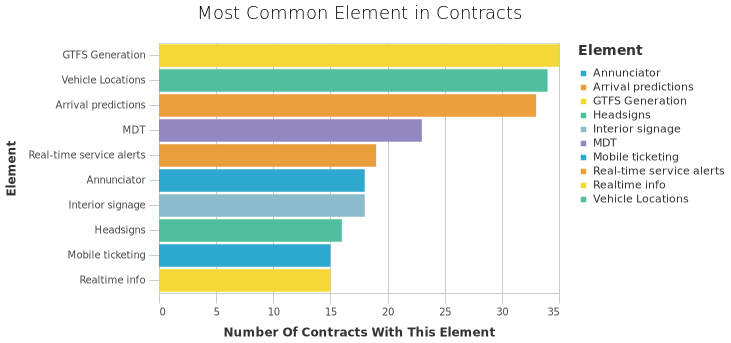 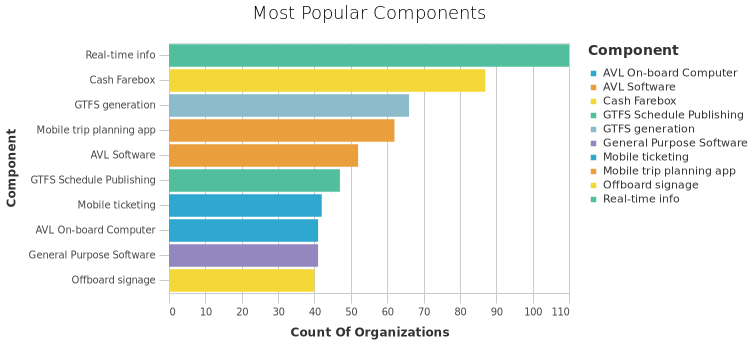

In [58]:
freq_df = (
    freq_df[(freq_df["Number of Times Duplicate Components Appears in Products"] > 0)]
    .groupby(["Component"])
    .agg({"Count of Organizations": "sum"})
    .sort_values("Count of Organizations", ascending=False)
    .head(10)
    .reset_index()
)

utils.basic_bar_chart(
    freq_df,
    "Count of Organizations",
    "Component",
    "Component",
    "Most Popular Components",
)

## Vendor x Component
***

* Looking at the vendor that is the most popular by component. 
    * AKA which vendor has the most unique customers for a particular component.
* GMV Syncromatics Inc is the most frequent vendor - 7 out of the 27 components.

In [59]:
vendor_comp = (
    service_components2.groupby(
        ["components_orgs_actually_use", "vendor__from_product_"]
    )
    .agg({"services": "nunique"})
    .rename(columns={"services": "Number of Customers"})
    .reset_index()
)

In [60]:
# Only keep the vendor with a particular component that is most popular.
# https://stackoverflow.com/questions/43899886/how-do-i-just-keep-the-rows-with-the-maximum-value-in-a-column-for-items-of-the
vendor_comp2 = vendor_comp.loc[
    vendor_comp.groupby("components_orgs_actually_use")["Number of Customers"].idxmax()
].rename(
    columns={
        "components_orgs_actually_use": "Component",
        "vendor__from_product_": "Most Frequent Vendor",
    }
)

In [61]:
len(vendor_comp2)

26

In [62]:
vendor_comp2

,Component,Most Frequent Vendor,Number of Customers
0,APC Sensors,UTA,1
17,APC Software,UTA,12
20,AVL On-board Computer,Connexionz Inc.,1
31,AVL Software,GMV Syncromatics Inc,17
51,Alerts Content Management System,GMV Syncromatics Inc,7
68,Annunciator,GMV Syncromatics Inc,11
84,Arrival predictions,GMV Syncromatics Inc,17
92,Cash Farebox,Genfare,52
97,Contactless Payment Validators,Token Transit,2
98,Fare card system,Sacramento Area Council of Governments,5


In [63]:
vendor_comp2["Most Frequent Vendor"].value_counts()

GMV Syncromatics Inc                      7
UTA                                       2
Connexionz Inc.                           2
Genfare                                   2
Token Transit                             2
Trillium Inc.                             2
Sacramento Area Council of Governments    1
Hanover Displays Ltd                      1
TransTrack Solutions Group                1
Elavon                                    1
Transit App Inc.                          1
IBI                                       1
N/A                                       1
Cubic                                     1
Microsoft                                 1
Name: Most Frequent Vendor, dtype: int64

### Which vendors have the most components available for purchase
***
* Some different vendors are mixed together. Not sure how to address this. 
    * Dilax Inc., INIT SE. 
    * Optibus,GMV Syncromatics Inc
    * Hanover Displays Ltd,Clever Devices Ltd.	
    * and more..


In [64]:
# Change Uber Inc.
service_components3["vendor__from_product_"] = service_components3[
    "vendor__from_product_"
].replace({"Uber Inc.,Uber Inc.": "Uber Inc."})

In [65]:
# First group vendors by products and the # of components in the product - use MAX
vendor_most_comp = (
    service_components3.groupby(["vendor__from_product_", "product"])
    .agg({"number_of_components_avail": "max"})
    .reset_index()
)

In [66]:
# Second, group by vendor and sum up all the components among all their products.
vendor_most_comp = (
    vendor_most_comp.groupby(["vendor__from_product_"])
    .agg({"number_of_components_avail": "sum"})
    .reset_index()
    .sort_values("number_of_components_avail", ascending=False)
    .rename(
        columns={
            "vendor__from_product_": "Vendor",
            "number_of_components_avail": "Total Components",
        }
    )
)

In [67]:
# Take out N/A?
vendor_most_comp = vendor_most_comp.loc[vendor_most_comp["Vendor"] != "N/A"]

In [68]:
vendor_most_comp

,Vendor,Total Components
94,Uber Inc.,22
33,GMV Syncromatics Inc,22
42,Hanover Displays Ltd,18
88,Trapeze Group,17
79,Swiftly Inc.,16
52,Luminator Technology Group,13
95,VenTek,12
27,ETA Transit Inc.,11
17,Connexionz Inc.,11
24,"Dilax Inc.,INIT SE",9


## Parent Company x Component
***

In [69]:
# As there are a lot of N/A for the parent org, filter out N/A
parent_comp = service_components2.loc[
    service_components2["parent_organization__from_vendor___from_product_"] != "N/A"
]

In [70]:
# Same thing as above
parent_comp2 = (
    parent_comp.groupby(
        [
            "components_orgs_actually_use",
            "parent_organization__from_vendor___from_product_",
        ]
    )
    .agg({"services": "nunique"})
    .rename(columns={"services": "Number of Customers"})
)

In [71]:
parent_comp2 = (
    parent_comp2.loc[
        parent_comp2.groupby("components_orgs_actually_use")[
            "Number of Customers"
        ].idxmax()
    ]
    .reset_index()
    .rename(
        columns={
            "components_orgs_actually_use": "Components",
            "parent_organization__from_vendor___from_product_": "Parent Company",
        }
    )
)

In [72]:
parent_comp2

,Components,Parent Company,Number of Customers
0,APC Software,GMV S.A.,7
1,AVL Software,GMV S.A.,18
2,Alerts Content Management System,GMV S.A.,7
3,Annunciator,GMV S.A.,11
4,Arrival predictions,GMV S.A.,18
5,GTFS generation,Modaxo Inc,12
6,Headsigns,GMV S.A.,7
7,Interior signage,GMV S.A.,9
8,KPI Reporting,Modaxo Inc,2
9,Mobile data terminal software,GMV S.A.,15
